## DDH model EOS inference pipeline

This section outlines the implementation of the density-dependent Hartree (DDH) model within an inference framework. It discusses how to incorporate various likelihood calculations such as perturbative Quantum Chromodynamics (pQCD), Chiral Effective Field Theory (chiEFT), constraints from the maximum mass of neutron stars, and nuclear saturation properties.

### Advantages of the DDH Approach

The DDH model provides a significant advantage over models with constant couplings by accounting for quantal fluctuations of the baryon fields even in the ground state, providing a more realistic depiction of nuclear matter under extreme conditions (refer to [Furnstahl et al., 1994](https://doi.org/10.1016/0370-2693(94)01664-X)).

### Literature Overview

Over the years, various authors have proposed different functional forms of density-dependent coupling schemes for the $ \sigma $, $ \omega $, and $ \rho $ mesons:

1. **Typel 1999 Model** ([Typel & Wolter, 1999](https://doi.org/10.1016/S0375-9474(99)00310-3)):
   - The coupling constants $ \Gamma_i(\rho) $ for $ i = \sigma, \omega $ are parametrized as:
   \begin{equation}
   \Gamma_i(\rho) = \Gamma_i(\rho_{\text{sat}}) \cdot f_i(x)
   \end{equation}
   - Where $ f_i(x) $ is defined by:
   \begin{equation}
   f_i(x) = a_i \frac{1 + b_i (x + d_i)^2}{1 + c_i (x + d_i)^2}
   \end{equation}
   - And for the $ \rho $-meson:
   \begin{equation}
   \Gamma_\rho(\rho) = \Gamma_\rho(\rho_{\text{sat}}) \cdot \exp \left[-a_\rho (x - 1)\right]
   \end{equation}

2. **Malik 2023 Model** ([Malik, 2023](https://doi.org/10.3847/1538-4357/ac5d3c)):
   - This model extends the coupling parametrization to:
   \begin{equation}
   \Gamma_M(\rho) = \Gamma_{M,0} \cdot h_M(x), \quad x = \rho / \rho_0
   \end{equation}
   - The functions are defined as:
     - For isoscalar ($ \sigma $ and $ \omega $):
     \begin{equation}
     h_M(x) = \exp[-(x^{a_M} - 1)]
     \end{equation}
     - For isovector ($ \rho $):
     \begin{equation}
     h_\rho(x) = \exp[-a_\rho (x - 1)]
     \end{equation}

3. **Gogelein 2008 Model** ([Gogelein, 2008](https://doi.org/10.1103/PhysRevC.77.025802); Utilized by Char 2023):
   - The density dependence for meson couplings is expressed as:
   \begin{equation}
   \Gamma_i(n_B) = a_i + (b_i + d_i x^3) \cdot e^{-c_i x}, \quad x = n_B / n_0
   \end{equation}
   - This model allows flexible control across different density regimes, ideal for Bayesian inference applications.

These models are crucial in the study of dense nuclear matter, providing the groundwork for robust statistical analyses and theoretical predictions within the framework of nuclear astrophysics.

In [1]:
import InferenceWorkflow.BayesianSampler as sampler
import InferenceWorkflow.Likelihood as likelihood
from InferenceWorkflow.DDH_Likelihood import Likelihood as ddh_likelihood
import InferenceWorkflow.prior as prior
import TOVsolver.main as tov
import EOSgenerators.RMF_DDH as DDH

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from TOVsolver.unit import g_cm_3, dyn_cm_2, km, Msun, MeV, fm
from TOVsolver.maxium_central_density import maxium_central_density
from TOVsolver.constant import oneoverfm_MeV,G,c
from scipy.interpolate import CubicSpline, InterpolatedUnivariateSpline, interp1d

import warnings
warnings.filterwarnings('ignore')

### Set up prior ranges (DDH model ([Malik, 2023] https://doi.org/10.3847/1538-4357/ac5d3c ))

In [2]:
parameters = ["as_", "av", "ar", "gs0", "gv0", "grho0", "rho0"]
 
def prior_transform(cube):
    params    = cube.copy()
    params[0] = prior.flat_prior(0,0.3 ,cube[0])
    params[1] = prior.flat_prior(0,0.3 ,cube[1])
    params[2] = prior.flat_prior(0,1.3 ,cube[2])
    params[3] = prior.flat_prior(6.5,13.5 ,cube[3])
    params[4] = prior.flat_prior(7.5,14.5 ,cube[4])
    params[5] = prior.flat_prior(5,16 ,cube[5])
    params[6] = prior.normal_Prior(0.153, 0.005,cube[6])

    return params

### Setup Likelihood (DDH model ([Malik, 2023] https://doi.org/10.3847/1538-4357/ac5d3c ))

### `likelihood_transform` Function 

The `likelihood_transform` function computes the total log-likelihood for a given set of parameters that define neutron star and nuclear matter properties. It uses a combination of nuclear saturation properties, maximum mass constraints, chiEFT constraints, and pQCD constraints.

#### Parameters

- `para` (`array`): An array of parameters that define the coupling constants and other relevant physical properties for the model.

#### Returns

- `float`: The total log-likelihood of the parameter set, which combines contributions from nuclear saturation properties, neutron star mass constraints, chiEFT constraints, and pQCD constraints. If the resulting log-likelihood is `-inf`, it is converted to `-1e20` for computational stability.

#### Function Details

#### 1. Define Meson Masses
The function begins by defining the meson masses in femtometer (fm) units:
- `m_sig`: Sigma meson mass (550 MeV)
- `m_w`: Omega meson mass (783 MeV)
- `m_rho`: Rho meson mass (763 MeV)
- `rho0`: Saturation density, taken as the last element in the `para` array.

#### 2. Density-Dependent Coupling for $\sigma$, $\omega$, and $\rho$
The density-dependent couplings are calculated using the `DDH.Function` method, which applies the Malik22 model type for density-dependent coupling in this example. To use a different model type, you would need to modify the `'prior_transform'` function and specify the desired model type within `'likelihood_transform'`, as each model type may require a different number of parameters. The calculated coupling values from `para` are then assembled into a single array, `theta`, which is used for subsequent calculations.

#### 3. Nuclear Matter Properties (NMP) Log-Likelihood
The nuclear matter properties (NMP) log-likelihood is computed by initializing a `DDH_Log_Likelihood` object, `DDH_like`, using `theta`. 
- The log-likelihood for NMP is computed using `DDH_like.compute_NMP()`.

#### 4. Neutron Star Maximum Mass Log-Likelihood
The log-likelihood contribution based on neutron star maximum mass is calculated using `DDH_like.compute_MR()`. This function returns:
- `0` if the maximum mass (`M_max`) is above 2 solar masses.
- `-inf` if `M_max` is below 2 solar masses.

The step function used for this calculation is smooth, similar to a Fermi-Dirac distribution, allowing for a gradual transition.

#### 5. chiEFT Constraints
The function then applies chiEFT constraints on pure neutron matter (PNM) using:
- `theta1`, which is `theta` with an additional element `0.0` for pure neutron matter.
- `DDH.compute_eos_alpha(theta1)`, which generates the equation of state (EOS) for PNM. 

The chiEFT likelihood is computed for PNM EOS using `log_EFT = likelihood.chiEFT_PNM(...)`. Units PNM EOS needs to be  converted to MeV.fm^-3.

#### 6. pQCD Constraints
Finally, the pQCD constraints are applied on the beta equilibrium EOS using `DDH.compute_eos(...)`:
- EOS units needs to be converted to GeV.fm^-3 as required by the pQCD likelihood.
- `log_pQCD` is computed using `likelihood.ln_pQCD(...)`, applied at a density of `8 * 0.16 fm^-3` to ensure the neutron star maximum mass stays below this density.

#### 7. Total Log-Likelihood Calculation
The total log-likelihood `log_tot` is calculated by summing:
- `log_NMP`, `log_MR`, `log_EFT`, and `log_pQCD`.

If `log_tot` is `-inf`, it is set to `-1e20` to avoid numerical issues.

#### Example Usage

```python
para = [0.086372, 0.054065, 0.509147, 9.180364, 10.981329, 7.652728, 0.150]
log_likelihood = likelihood_transform(para)
print(log_likelihood)


In [3]:
def likelihood_transform(para):
    """
    Compute the log-likelihood of a given parameter set for neutron star and nuclear matter properties.
    
    Parameters:
    para (array): Array of parameters defining the couplings and other physical properties.
    
    Returns:
    float: The total log-likelihood of the parameter set.
    """
    
    # Define the meson masses in fm scale
    m_sig = 550 / oneoverfm_MeV
    m_w = 783 / oneoverfm_MeV
    m_rho = 763 / oneoverfm_MeV
    rho0 = para[-1]
    
    # Calculate the density-dependent coupling factors
    gsf, gwf, grf, dgsf, dgwf, dgrf = DDH.Function(type='Malik22', couplings=para)
    theta = np.array([m_sig, m_w, m_rho, gsf, gwf, grf, dgsf, dgwf, dgrf, rho0])
    
   
    # Define log-likelihood for Nuclear Matter Properties (NMP) at nuclear saturation properties
    # Default Gaussian constraints: self.NMP_Base = {"e0":[-16, 0.2, 'g'], "k0":[230, 40, 'g'], "jsym0":[32.5, 1.8, 'g']}
    # You may update these values using the update_base and update_quantities methods in the DDH_Log_Likelihood class.
    DDH_like = ddh_likelihood(theta)
    
    #1. This block for compute log-likelihood for Nuclear Matter Properties (NMP)
    log_NMP = DDH_like.compute_NMP()
    
    #2. Compute log-likelihood for NS maximum mass, returning 0 if M_max ≥ 2 and -∞ if M_max < 2
    # The step function is smooth, like a Fermi-Dirac distribution, providing a smooth transition
    log_MR = DDH_like.compute_MR()
    
    #3. Apply chiEFT constraints to pure neutron matter EOS
    theta1 = np.concatenate((theta, np.array([0.0])))  # Alpha = 0 for pure neutron matter
    EOS_pnm = np.array(DDH.compute_eos_alpha(theta1))
    
    #4. chiEFT likelihood input requires MeV.fm^-3 units for both energy (e) and pressure (p)
    EOS_pnm[1] *= oneoverfm_MeV
    EOS_pnm[2] *= oneoverfm_MeV
    
    log_EFT = likelihood.chiEFT_PNM(EOS_pnm, type="Super Gaussian", contraint_quantity="p", enlargement=1.0)  # 100% enlargement for energy in PNM
    
    #5. Apply pQCD constraints on beta equilibrium EOS
    EOS_beta = np.array(DDH.compute_eos([0],[0],theta))
    EOS_beta[1] *= oneoverfm_MeV / 1000  # pQCD likelihood input requires GeV.fm^-3 units for both e and p
    EOS_beta[2] *= oneoverfm_MeV / 1000
    
    log_pQCD = likelihood.ln_pQCD(EOS_beta, [7 * 0.16])  # pQCD applied at 7 * 0.16 fm^-3, ensuring NS max mass is below this density
    
        
    # Total log-likelihood
    log_tot = log_NMP + log_MR + log_EFT + log_pQCD
    
    if log_tot == -np.inf:
        log_tot = -1e301
    
    return log_tot

### Test log_likelihood function 

In [4]:
%%timeit
para =[0.086372, 0.054065, 0.509147, 9.180364, 10.981329, 3.826364*2, 0.150]
print(likelihood_transform(para))

-5.739301623110369
-5.739301623110369
-5.739301623110369
-5.739301623110369
-5.739301623110369
-5.739301623110369
-5.739301623110369
-5.739301623110369
614 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Inference

In [ ]:
step = 2 * len(parameters)
live_point = 2000

max_calls = 500000
samples = sampler.UltranestSampler(parameters,likelihood_transform,prior_transform,step,live_point,max_calls)

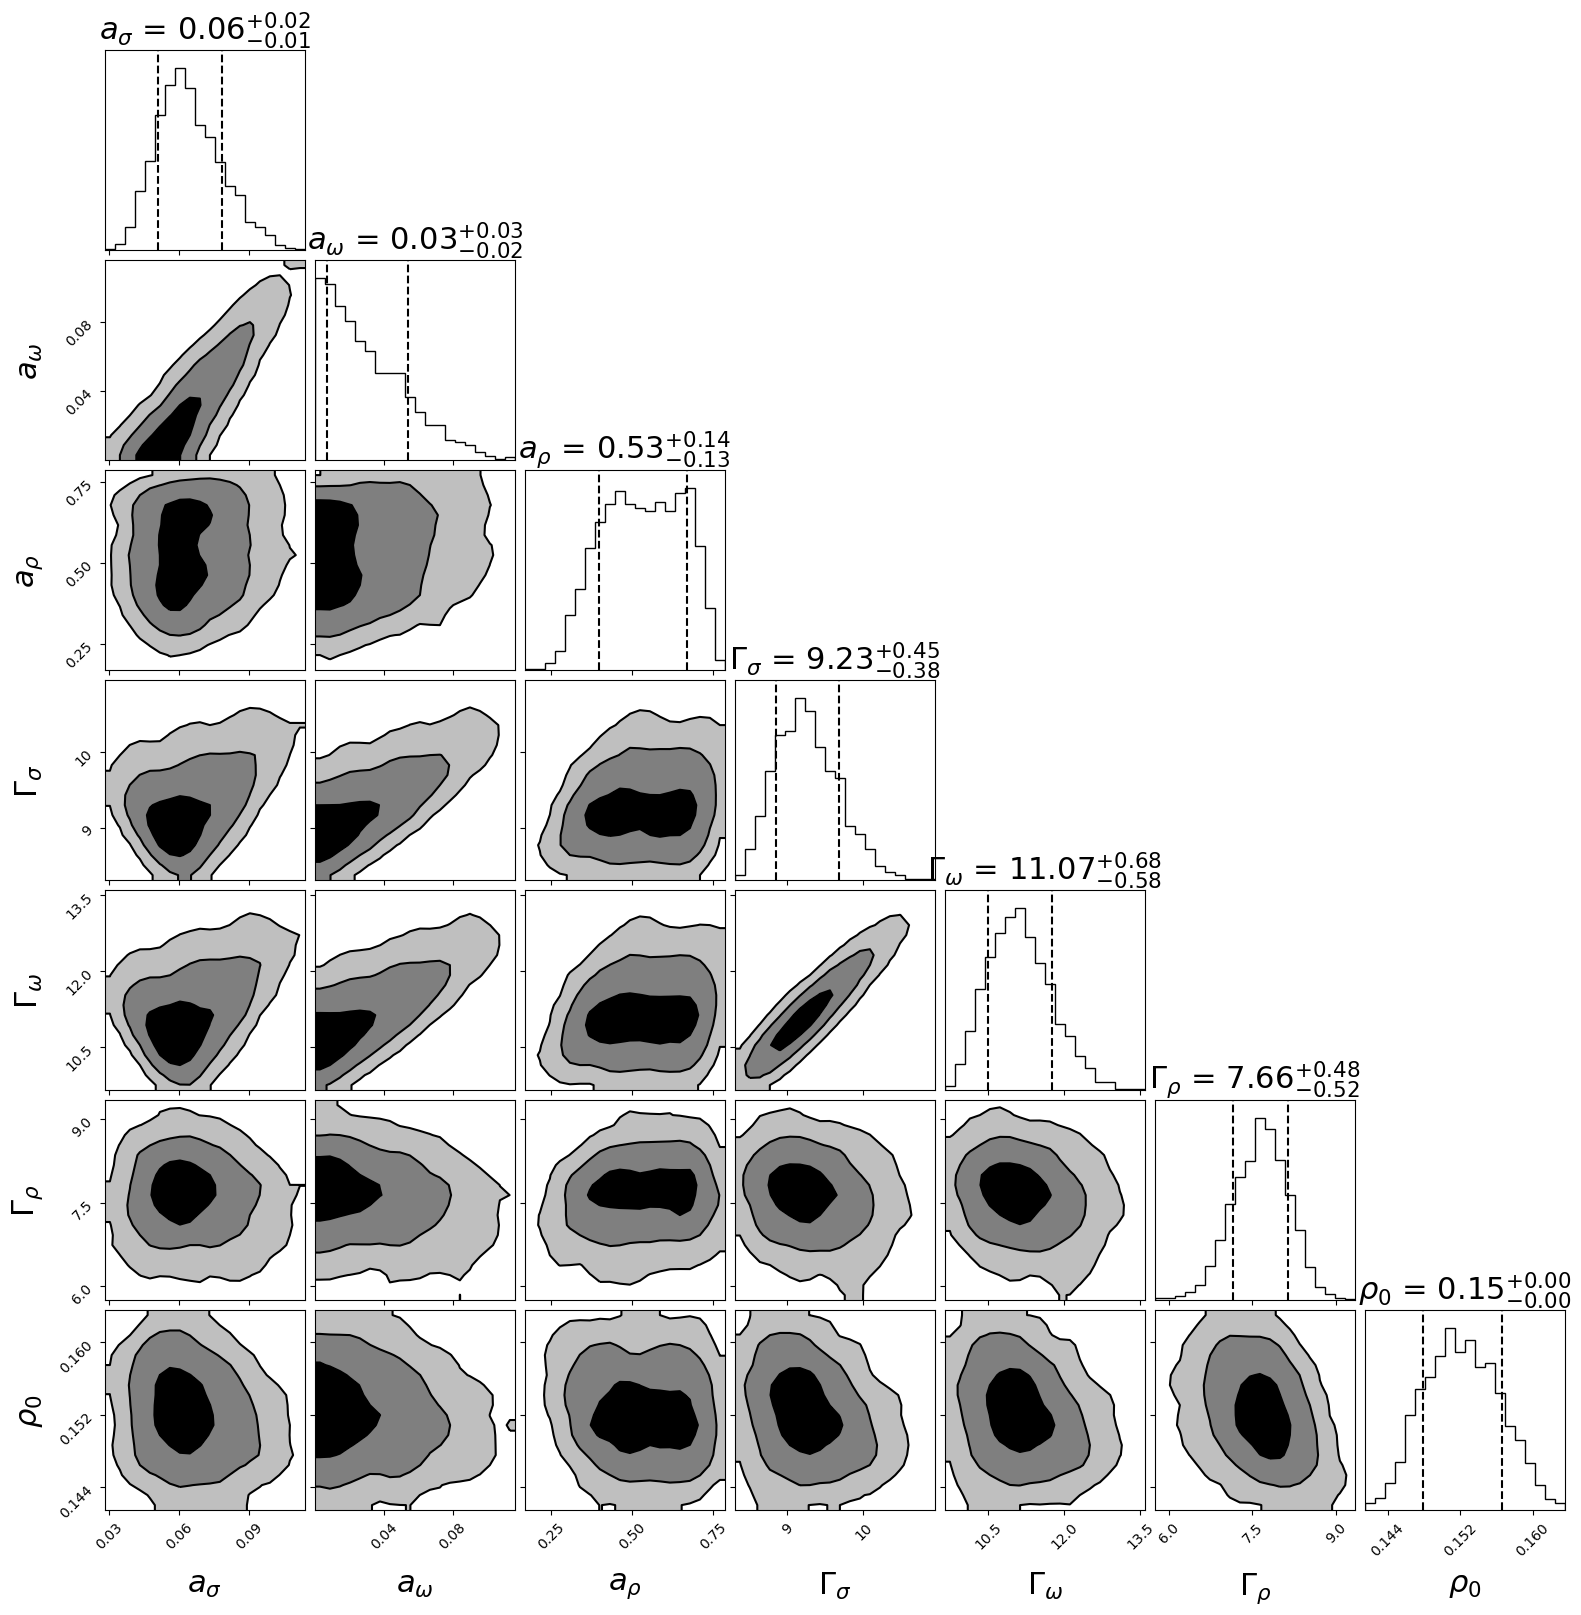

In [6]:
import corner

figure = corner.corner(samples,labels=[ r"$a_{\sigma}$", r"$a_{\omega}$",r"$a_{\rho}$", r"$\Gamma_{\sigma}$", r"$\Gamma_{\omega}$",r"$\Gamma_{\rho}$", r"$\rho_0$"],
                    smooth=0.9,
                    label_kwargs=dict(fontsize=22),
                    title_kwargs=dict(fontsize=22),
                    quantiles=[0.16, 0.84],
                    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
                    plot_density=False,
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    max_n_ticks=3,
                    title_fmt= '.2f')
                       #,range=[(10,80),(0.56,0.64),(0.10, 0.2),(150,600),(40,80),(50,75)])